In [87]:
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import *

In [88]:
df = pd.read_csv("./DATA/Emotions/emotions.csv")

In [89]:
num_columns = len(df.columns)
print(len(df.index), num_columns)

2132 2549


In [90]:
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

def Oversample(data, labels):
    zeros = []
    ones = []
    for (index, label) in enumerate(labels):
        if label == 0:
            zeros.append(data[index])
        else:
            ones.append(data[index])

    zeros, ones = np.array(zeros), np.array(ones)
    ids = np.arange(len(ones))
    choices = np.random.choice(ids, len(zeros)) #choose entries from so that number of ones and zeroes are the same 

    res_ones_features = ones[choices]
    res_ones_labels = np.ones(len(res_ones_features))

    resampled_features = np.concatenate([res_ones_features, zeros], axis=0)
    resampled_labels = np.concatenate([res_ones_labels, np.zeros(len(zeros))], axis=0)

    return unison_shuffled_copies(resampled_features, resampled_labels)
        

In [91]:
df.head() #each row represents one second

,# mean_0_a,mean_1_a,mean_2_a,mean_3_a,mean_4_a,mean_d_0_a,mean_d_1_a,mean_d_2_a,mean_d_3_a,mean_d_4_a,...,fft_741_b,fft_742_b,fft_743_b,fft_744_b,fft_745_b,fft_746_b,fft_747_b,fft_748_b,fft_749_b,label
0,4.62,30.3,-356.0,15.6,26.3,1.070,0.411,-15.70,2.06,3.15,...,23.5,20.3,20.3,23.5,-215.0,280.00,-162.00,-162.00,280.00,NEGATIVE
1,28.80,33.1,32.0,25.8,22.8,6.550,1.680,2.88,3.83,-4.82,...,-23.3,-21.8,-21.8,-23.3,182.0,2.57,-31.60,-31.60,2.57,NEUTRAL
2,8.90,29.4,-416.0,16.7,23.7,79.900,3.360,90.20,89.90,2.03,...,462.0,-233.0,-233.0,462.0,-267.0,281.00,-148.00,-148.00,281.00,POSITIVE
3,14.90,31.6,-143.0,19.8,24.3,-0.584,-0.284,8.82,2.30,-1.97,...,299.0,-243.0,-243.0,299.0,132.0,-12.40,9.53,9.53,-12.40,POSITIVE
4,28.30,31.3,45.2,27.3,24.5,34.800,-5.790,3.06,41.40,5.52,...,12.0,38.1,38.1,12.0,119.0,-17.60,23.90,23.90,-17.60,NEUTRAL


In [92]:
df = df.sample(frac=1) #shuffle dataset
data = df.drop(['label'], axis=1).to_numpy()
labels = df['label'].to_numpy()

In [93]:
all_labels = list(set(labels))
print(all_labels)
class_labels = tfds.features.ClassLabel(names=all_labels)
labels = np.array([class_labels.str2int(x) for x in labels])

['NEUTRAL', 'POSITIVE', 'NEGATIVE']


In [94]:
norm = np.linalg.norm(data, axis=0)
data = data/norm

In [95]:
assert(len(data) == len(labels))
train, validate, test = np.split(data, [int(.6*len(data)), int(.8*len(data))])
train_labels, validate_labels, test_labels = np.split(labels, [int(.6*len(labels)), int(.8*len(labels))])

In [96]:
TIMESTEPS = 1
def Reshape(input):
    size, features = input.shape
    return input.reshape(size, TIMESTEPS, features)
train, validate, test = Reshape(train), Reshape(validate), Reshape(test)

Class Weighting

Build and Train The Model

In [106]:
EPOCHS = 30
BATCH_SIZE = 64
INPUT_SHAPE = (TIMESTEPS, num_columns-1)
DROPOUT = 0.2
FILTERS = 16
UNITS = 16
POOL_SIZE = 1

In [115]:
def Model():
    input = layers.Input(shape=INPUT_SHAPE)
    conv1 = layers.Conv1D(FILTERS, kernel_size=1)(input)
    pool1 = layers.MaxPool1D(POOL_SIZE)(conv1)
    conv2 = layers.Conv1D(FILTERS*2, kernel_size=1)(pool1)
    pool2 = layers.MaxPool1D(POOL_SIZE)(conv2)
    conv3 = layers.Conv1D(FILTERS*3, kernel_size=1)(pool2)
    pool3 = layers.MaxPool1D(POOL_SIZE)(conv3)

    flatten = layers.Flatten()(pool3)
    fc1 = layers.Dense(UNITS, activation = 'relu')(flatten)
    d1 = layers.Dropout(DROPOUT)(fc1)
    fc2 = layers.Dense(UNITS, activation = 'relu')(d1)
    d2 = layers.Dropout(DROPOUT)(fc2)

    output = layers.Dense(3, activation='softmax')(d2)
    model = tf.keras.Model(inputs=input, outputs=output)
    return model
model = Model()
model.summary()

Model: "functional_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 1, 2548)]         0         
_________________________________________________________________
conv1d_19 (Conv1D)           (None, 1, 16)             40784     
_________________________________________________________________
max_pooling1d_17 (MaxPooling (None, 1, 16)             0         
_________________________________________________________________
conv1d_20 (Conv1D)           (None, 1, 32)             544       
_________________________________________________________________
max_pooling1d_18 (MaxPooling (None, 1, 32)             0         
_________________________________________________________________
conv1d_21 (Conv1D)           (None, 1, 48)             1584      
_________________________________________________________________
max_pooling1d_19 (MaxPooling (None, 1, 48)           

In [116]:
model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [117]:
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=5)

history = model.fit(train, train_labels, 
epochs=EPOCHS, 
validation_data=(validate, validate_labels), 
batch_size=BATCH_SIZE, 
verbose=2, 
callbacks=[callback],
# class_weight=class_weight,
shuffle=True)

Epoch 1/30
20/20 - 0s - loss: 1.0379 - accuracy: 0.5106 - val_loss: 0.9628 - val_accuracy: 0.6408
Epoch 2/30
20/20 - 0s - loss: 0.9567 - accuracy: 0.6685 - val_loss: 0.9225 - val_accuracy: 0.6995
Epoch 3/30
20/20 - 0s - loss: 0.9135 - accuracy: 0.7318 - val_loss: 0.8670 - val_accuracy: 0.7934
Epoch 4/30
20/20 - 0s - loss: 0.8270 - accuracy: 0.8249 - val_loss: 0.7499 - val_accuracy: 0.8826
Epoch 5/30
20/20 - 0s - loss: 0.7310 - accuracy: 0.8538 - val_loss: 0.6649 - val_accuracy: 0.9108
Epoch 6/30
20/20 - 0s - loss: 0.6901 - accuracy: 0.8780 - val_loss: 0.6505 - val_accuracy: 0.9108
Epoch 7/30
20/20 - 0s - loss: 0.6699 - accuracy: 0.8913 - val_loss: 0.6472 - val_accuracy: 0.9108
Epoch 8/30
20/20 - 0s - loss: 0.6577 - accuracy: 0.9046 - val_loss: 0.6416 - val_accuracy: 0.9108
Epoch 9/30
20/20 - 0s - loss: 0.6547 - accuracy: 0.9046 - val_loss: 0.6364 - val_accuracy: 0.9155
Epoch 10/30
20/20 - 0s - loss: 0.6478 - accuracy: 0.9085 - val_loss: 0.6380 - val_accuracy: 0.9131
Epoch 11/30
20/20 -

In [118]:
# model.save("./Models/Epilepsy_LSTM1.h5")

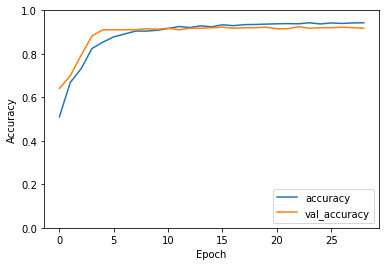

In [119]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

In [120]:
test_loss, test_acc = model.evaluate(test,  test_labels, verbose=2)

14/14 - 0s - loss: 0.6149 - accuracy: 0.9344


In [121]:
test_labels[:50]

array([0, 0, 2, 2, 2, 1, 2, 1, 0, 2, 1, 2, 1, 1, 0, 2, 0, 1, 1, 0, 1, 0,
       0, 0, 1, 1, 2, 2, 0, 0, 1, 2, 1, 0, 0, 2, 2, 2, 0, 2, 2, 2, 1, 1,
       1, 2, 0, 2, 0, 0])

In [122]:
# prediction = model.predict(np.expand_dims(test[0], axis=0))
prediction = model.predict(test)
print(prediction.shape)
for (index,p) in enumerate(prediction[:50]):
    # print(p)
    print(class_labels.int2str(np.argmax(p)), class_labels.int2str(test_labels[index]))
    # print(np.argmax(prediction))

(427, 3)
NEUTRAL NEUTRAL
NEUTRAL NEUTRAL
NEGATIVE NEGATIVE
NEGATIVE NEGATIVE
NEGATIVE NEGATIVE
POSITIVE POSITIVE
NEGATIVE NEGATIVE
POSITIVE POSITIVE
NEUTRAL NEUTRAL
NEGATIVE NEGATIVE
POSITIVE POSITIVE
NEGATIVE NEGATIVE
POSITIVE POSITIVE
POSITIVE POSITIVE
NEUTRAL NEUTRAL
NEGATIVE NEGATIVE
NEUTRAL NEUTRAL
POSITIVE POSITIVE
POSITIVE POSITIVE
NEUTRAL NEUTRAL
POSITIVE POSITIVE
NEUTRAL NEUTRAL
NEUTRAL NEUTRAL
NEUTRAL NEUTRAL
POSITIVE POSITIVE
NEGATIVE POSITIVE
NEGATIVE NEGATIVE
NEGATIVE NEGATIVE
NEUTRAL NEUTRAL
NEUTRAL NEUTRAL
NEGATIVE POSITIVE
NEGATIVE NEGATIVE
POSITIVE POSITIVE
NEUTRAL NEUTRAL
NEUTRAL NEUTRAL
NEGATIVE NEGATIVE
NEGATIVE NEGATIVE
NEGATIVE NEGATIVE
NEUTRAL NEUTRAL
NEGATIVE NEGATIVE
NEGATIVE NEGATIVE
NEGATIVE NEGATIVE
NEGATIVE POSITIVE
POSITIVE POSITIVE
POSITIVE POSITIVE
NEGATIVE NEGATIVE
NEUTRAL NEUTRAL
NEGATIVE NEGATIVE
NEUTRAL NEUTRAL
NEUTRAL NEUTRAL
